In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.manifold import TSNE
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import pandas as pd

In [5]:
with open('../data/key_embed.pkl', 'rb') as handle:
    data = pickle.load(handle)

In [8]:
keys = []
vals = []
for key,value in data.items():
    keys.append(key)
    vals.append(value)
    

In [11]:
tsne = TSNE(n_components=2,perplexity=5) 
Y = tsne.fit_transform(vals)

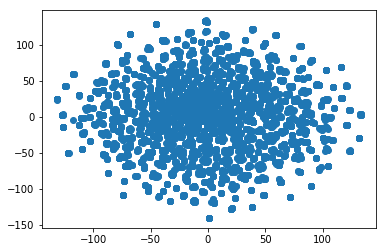

In [12]:
plt.scatter(Y[:,0],Y[:,1])
plt.show()

In [62]:

X = vals
db = DBSCAN(eps=1., min_samples=2).fit(X)

In [63]:


core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


Estimated number of clusters: 311
Estimated number of noise points: 199


In [79]:
np.array(keys)[labels==21]

array(['[122] High Press Tank Level', '[374] #1 Tail Seal Tank Level',
       '[375] #2 Tail Seal Tank Level', '[376] #3 Tail Seal Tank Level',
       '[583] No.1 A Liquid Agitator Tank Level',
       '[584] No.2 A Liquid Agitator Tank Level',
       '[585] No.3 A Liquid Agitator Tank Level',
       '[586] B Liquid Tank Level', '[749] No.1 Foam Liquid Tank Level',
       '[750] No.2 Foam Liquid Tank Level',
       '[751] No.1 Foam Agent Tank Level',
       '[754] No.1 Polymer Agent Tank Level',
       '[755] No.2 Polymer Agent Tank Level',
       '[838] Bentonite Refill Agitator Tank Level',
       '[883] No.1 Bentonite/Water Agitator Level',
       '[884] No.2 Bentonite/Water Agitator Level',
       '[2636] [c]Target Level',
       '[3944] Water (No.1 Refill) Agitator Tank Level',
       '[3954] No.3 Foam Liquid Tank Level',
       '[3955] No.2 Foam Agent Tank Level',
       '[4650] No.1 Foam Liquid Batch Mixing Start Level',
       '[4659] No.2 Foam Liquid Batch Mixing Start Level',


In [80]:
np.array(keys)[labels==-1]

array(['[2] [c]Record Date', '[3] [c]Record Time',
       '[6] Cutter total current',
       '[13] Articulation Deviation Upper-Lower',
       '[18] No.1 Grease Pause Time', '[19] No.1 Grease Feed Time',
       '[20] Cutter Total Revolution CCW',
       '[21] Cutter Total Revolution CW', '[22] Cutter Rotation Speed',
       '[35] Selection Average Earth Press (Upper)',
       '[36] Selection Average Earth Press (Middle)',
       '[37] Selection Average Earth Press (Lower)',
       '[72] Erector Oil Cooler FAN Current',
       '[75] Erector Jack Pressure',
       '[99] Primary Water #2 Screw Drive flow',
       '[100] Primary Water level',
       '[101] Secondary Water level for warm',
       '[102] Secondary Water level for cold',
       '[111] No.1 Secondary Water Pu Current Value',
       '[144] Primary Water Oil Tank outlet Temp (deck)',
       '[244] Soil Press (Earth Collapsing)',
       '[245] Wear Detecting Spoke Press',
       '[257] Earth Collapsing Detector Stroke',
       '[

# Clustering using original data and their cross correlation with lag0

In [2]:
data = pd.read_excel('../data/sample data SR99.xlsx')

In [14]:
# fill nan by column mean
data = data.fillna(0)
keys = data.keys()

In [15]:
time_series_data = []
inval_idx = []
valid_keys = []
pure_sig_keys = []
for i,k in enumerate(keys):
    if "Date" in k or "Time" in k:
        inval_idx.append(i)
    else: 
        x = np.array(data[k][1:])
        try: 
            x.astype(np.float64)
        except:
            inval_idx.append(i)
            continue
            
        d_min,d_max = x.min(),x.max()
        if d_min+d_max==1:
            pure_sig_keys.append(k)
            continue
       
        time_series_data.append(x)
        valid_keys.append(k)
print (len(keys),len(inval_idx),len(pure_sig_keys),len(valid_keys))

5975 148 1335 4492


In [16]:
new_data = pd.DataFrame(time_series_data).T

In [17]:
new_data.columns=valid_keys

In [18]:
def corr_dist_lag0(x,y):
    if len(x)!=len(y):
        raise RuntimeError("length of the input series should be same")
    x0 = x-np.mean(x)
    y0 = y-np.mean(y)
    l = len(x)
    return 1-abs((np.dot(x0,y0)/l)/(np.std(x)*np.std(y)))
    

In [19]:
db = DBSCAN(eps=0.1, min_samples=2,metric=corr_dist_lag0,n_jobs=-1).fit(time_series_data)

/Users/rj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/Users/rj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [20]:
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 351
Estimated number of noise points: 1583


In [108]:
cluster_item_count = []
for i in range(n_clusters_):
    cluster = np.array(valid_keys)[labels==i]
    num_items = len(cluster)
    cluster_item_count.append(num_items)

In [109]:
num_thre = 10
large_cluster_ids = [i for (i,n) in enumerate(cluster_item_count) if n>num_thre]
large_cluster_ids

[0, 3, 5, 11, 15, 19, 22, 41, 44, 53, 54, 84, 96, 109, 139, 145, 174]

In [138]:
group1_keys = np.array(valid_keys)[labels==109]
print (len(group1_keys),group1_keys)

12 ['[699] F19 AIR FLOW CUMULATIVE' '[700] F21 AIR FLOW CUMULATIVE'
 '[720] F19 FOAM LIQUID FLOW CUMULATIVE'
 '[721] F21 FOAM LIQUID FLOW CUMULATIVE' '[740] F19 FOAM FLOW CUMULATIVE'
 '[741] F21 FOAM FLOW CUMULATIVE' '[2784] [c]Foam 19 Volume(Ring)'
 '[2785] [c]Foam 20 Volume(Ring)' '[2826] [c]Air 19 Volume(Ring)'
 '[2827] [c]Air 20 Volume(Ring)' '[2925] [c]No.19 Foam Liquid Volume'
 '[2926] [c]No.20 Foam Liquid Volume']


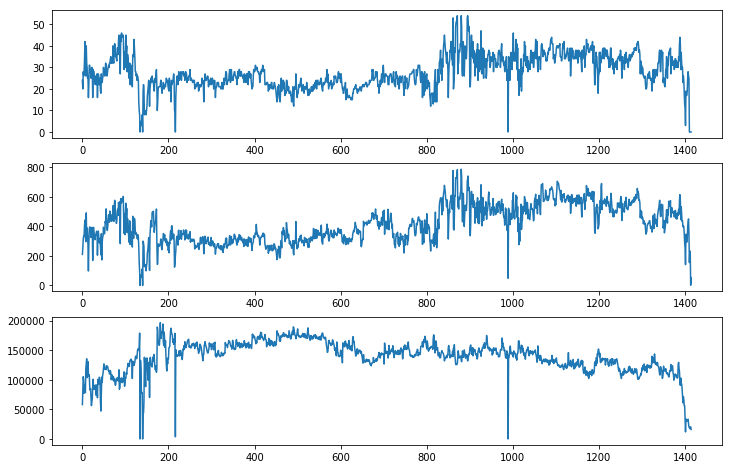

In [123]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(311)
plt.plot(new_data[group1_keys[1]])
ax2 = fig.add_subplot(312)
plt.plot(new_data[group1_keys[-1]])
ax3 = fig.add_subplot(313)
plt.plot(new_data[ '[9] Total Thrust Force'])
# ax4 = fig.add_subplot(414)
# plt.plot(new_data[ group1_keys[5]])
plt.show()

In [104]:
corr_dist_lag0(new_data[group1_keys[2]],new_data[group1_keys[0]])

0.6613587258186489